In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import log_loss #Since the competition uses log_loss as the performance metric
import pickle
import gc
import re
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
#Read files into pandas dataframes
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

**Data Exploration**

One of the most important parts of every data related/machine larning project's pipeline is getting to know the data we are dealing with. It is essential to have a good grasp of data's size, different data types present in the data, patterns (both usual and unusual), outliers, missing values, limitations of the data and potential biases. Having a thorough understanding in these concepts will allow us to generate relevant and effective features for the machine learning model.

In [3]:
train.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [4]:
test.head()

,test_id,question1,question2
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...
1,1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?
2,2,What but is the best way to send money from Ch...,What you send money to China?
3,3,Which food not emulsifiers?,What foods fibre?
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?


In [5]:
#Dimensions of the train and test data and some other observations 
print('Train file has %d rows and %d columns' %(train.shape[0], train.shape[1]))
print('Test file has %d rows and %d columns' %(test.shape[0], test.shape[1]))
qids = pd.Series(train.qid1.to_list() + train.qid2.to_list()) #Create a Series from question id's of train data
print('Number of unique questions %d' %(len(np.unique(qids))))
print('Number of questions that appear multiple times %d' %(sum(qids.value_counts() > 1)))

Train file has 404290 rows and 6 columns
Test file has 2345796 rows and 3 columns
Number of unique questions 537933
Number of questions that appear multiple times 111780


In [6]:
#Missing values in train data
train.isna().sum()

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

In [7]:
train[train.question1.isna()] #Missing values in train data's question1 column

,id,qid1,qid2,question1,question2,is_duplicate
363362,363362,493340,493341,NaN,My Chinese name is Haichao Yu. What English na...,0


In [8]:
train[train.question2.isna()]#Missing values in train data's question2 column

,id,qid1,qid2,question1,question2,is_duplicate
105780,105780,174363,174364,How can I develop android app?,NaN,0
201841,201841,303951,174364,How can I create an Android app?,NaN,0


Since we don't have many missing values and the ones we have are not duplicate, we can fill the missing values with empty string

In [9]:
train = train.fillna('')

In [10]:
print('Percentage of questions that are duplicated are %%%.2f' % (len(train[train.is_duplicate == 1]) / len(train)*100)  )

Percentage of questions that are duplicated are %36.92


#### Comparing character counts of train and test question pairs on a histogram

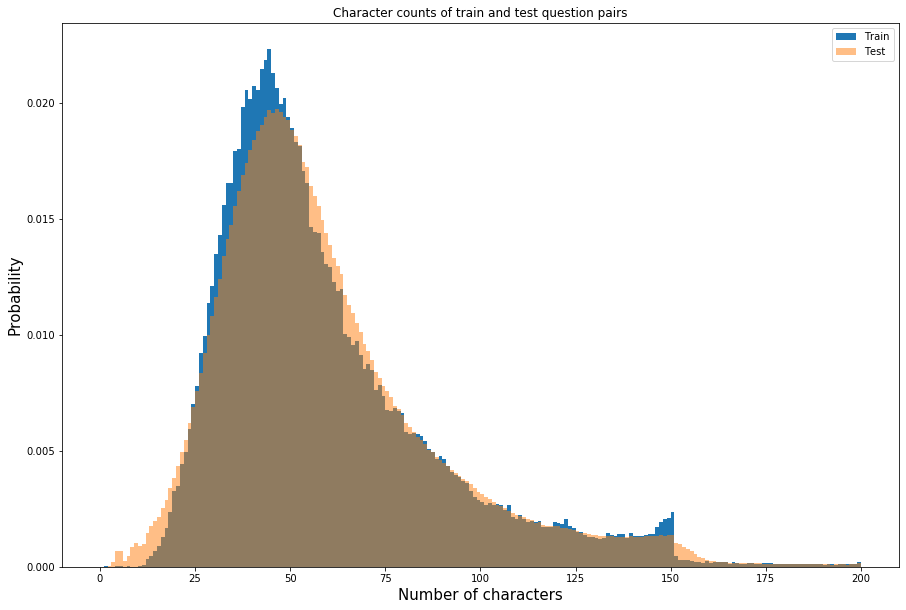

Mean of train character count 59.82 
Mean of test character count 60.07


In [11]:
train_qs = pd.Series(train['question1'].to_list() + train['question2'].to_list()).astype(str)
test_qs = pd.Series(test['question1'].to_list() + test['question2'].to_list()).astype(str)
train_dist = train_qs.apply(len)
test_dist = test_qs.apply(len)
plt.figure(figsize=(15,10))
plt.hist(train_dist, range=[0,200], bins=200, density=True, label='Train')
plt.hist(test_dist, range=[0,200], bins=200, density=True, label='Test', alpha=0.5)
plt.legend()
plt.title('Character counts of train and test question pairs')
plt.xlabel('Number of characters', fontsize=15)
plt.ylabel('Probability', fontsize=15)
plt.show()
print('Mean of train character count {:.2f} \nMean of test character count {:.2f}'.format(train_dist.mean(), 
                                                                                          test_dist.mean()))

#### Comparing word counts of train and test question pairs on a histogram

In this part of the data exploration, we will compare word counts of the questions in the train and test data

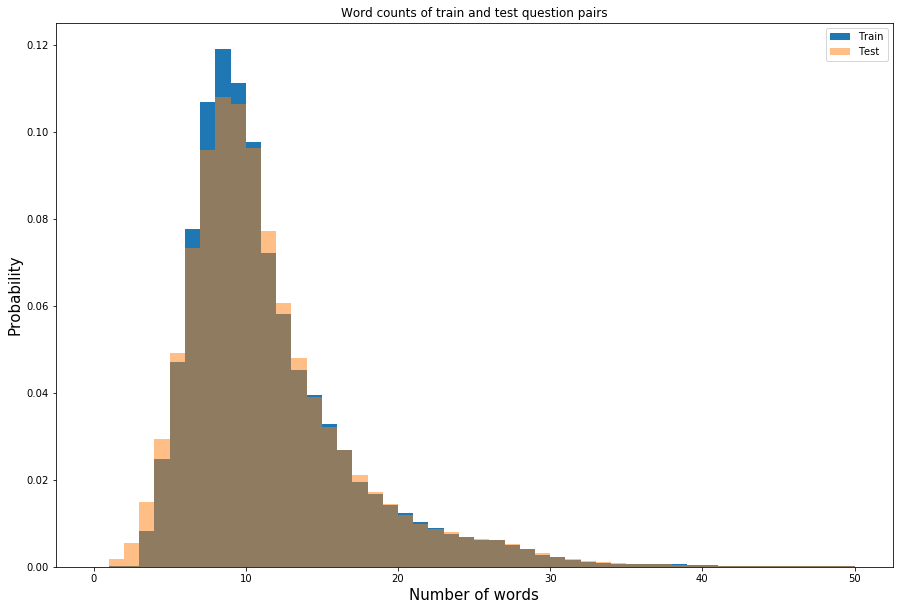

Mean of train word count 11.06 
Mean of test word count 11.02


In [12]:
train_dist = train_qs.apply(lambda x: len(x.split()))
test_dist = test_qs.apply(lambda x: len(x.split()))
plt.figure(figsize=(15,10))
plt.hist(train_dist, range=[0,50], bins=50, density=True, label='Train')
plt.hist(test_dist, range=[0,50], bins=50, density=True, label='Test', alpha=0.5)
plt.legend()
plt.title('Word counts of train and test question pairs')
plt.xlabel('Number of words', fontsize=15)
plt.ylabel('Probability', fontsize=15)
plt.show()
print('Mean of train word count {:.2f} \nMean of test word count {:.2f}'.format(train_dist.mean(), test_dist.mean()))

It seems like train and test data have very similar distribution of word count which is a positive thing since we will build our model based on training data, it is important that the model can generalize on test data

#### WordCloud of questions

Word cloud is a great visualisation tool for human eye to see most frequently occuring words so that we can detect potential patterns or biases in the data.

(-0.5, 1439.5, 1079.5, -0.5)

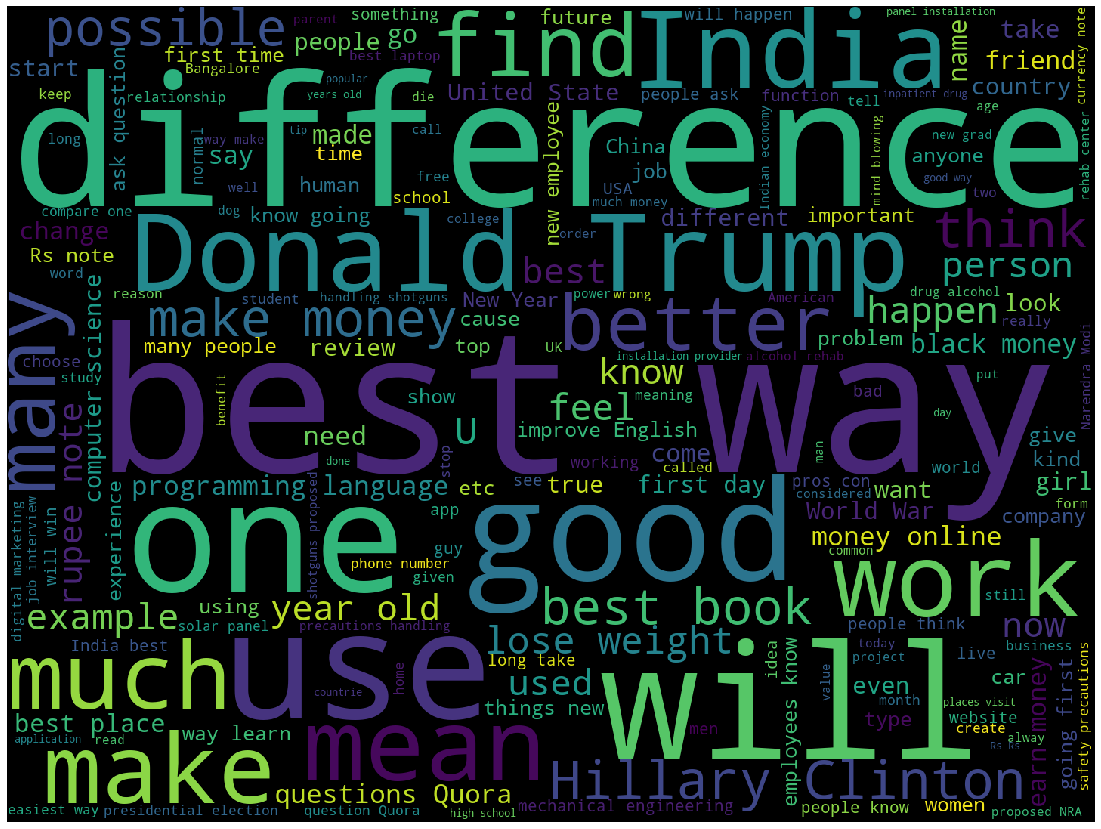

In [13]:
from wordcloud import WordCloud
cloud = WordCloud(width=1440, height=1080).generate(" ".join(train_qs.astype(str)))
plt.figure(figsize=(20,15))
plt.imshow(cloud)
plt.axis('off')

## Feature Generation

**Feature 1 - Set of features related to ratio of matching words in question pairs**

The first set of features we'll generate are rate of same(matching) words, rate of matching words over shorter question, rate of matching words over longer question, rate of matching words over difference of question lengths in question pairs after the stopwords are removed.

In [14]:
from nltk.corpus import stopwords

In [15]:
stops = set(stopwords.words('english')) #Create stop words set so that we can remove stopwords from questions

def matching_words_rate(q1, q2):
    match_rate_feats = [0.0] * 4
    epsilon = 0.001 #for division with 0
    
    q1_words = {}
    q2_words = {}
    
    for word in str(q1).lower().split():
        if word not in stops:
            q1_words[word] = 1
    
    for word in str(q2).lower().split():
        if word not in stops:
            q2_words[word] = 1
    
    if len(q1_words) == 0 or len(q2_words) == 0:
        return match_rate_feats
    
    q1_shared_words = [w for w in q1_words.keys() if w in q2_words]
    q2_shared_words = q1_shared_words
    
    match_rate_feats[0] = (len(q1_shared_words) + len(q2_shared_words)) / (len(q1_words) + len(q2_words))
    match_rate_feats[1] = len(q1_shared_words) / (min(len(q1_words), len(q2_words)) + epsilon)
    match_rate_feats[2] = len(q1_shared_words) / (max(len(q1_words), len(q2_words)) + epsilon)
    match_rate_feats[3] = len(q1_shared_words) / (abs(len(q1_words) - len(q2_words)) + epsilon)
    
    return match_rate_feats


In [16]:
train_match_rates = train.apply(lambda x: matching_words_rate(x["question1"], x["question2"]), axis=1)

In [17]:
match_word_rate = train_match_rates.apply(lambda x: x[0])
mwr_min = train_match_rates.apply(lambda x: x[1])
mwr_max = train_match_rates.apply(lambda x: x[2])
mwr_diff = train_match_rates.apply(lambda x: x[3])

We will plot a histogram for each feature to visualise how does the increase in each shared word ratio related feature accounts for whether a pair of questions are duplicate or not

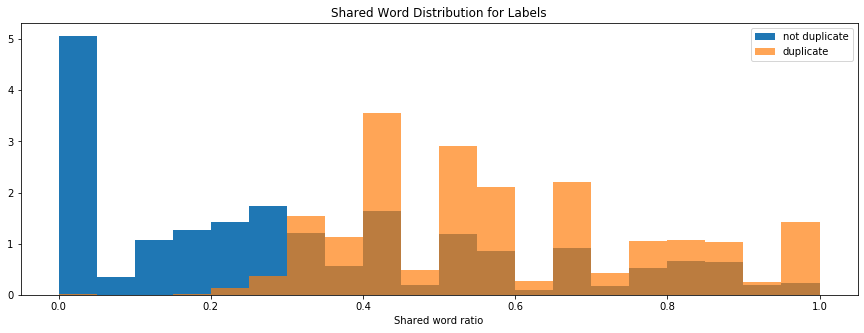

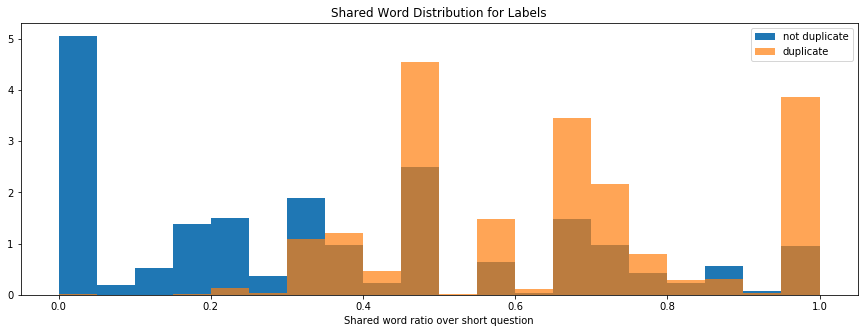

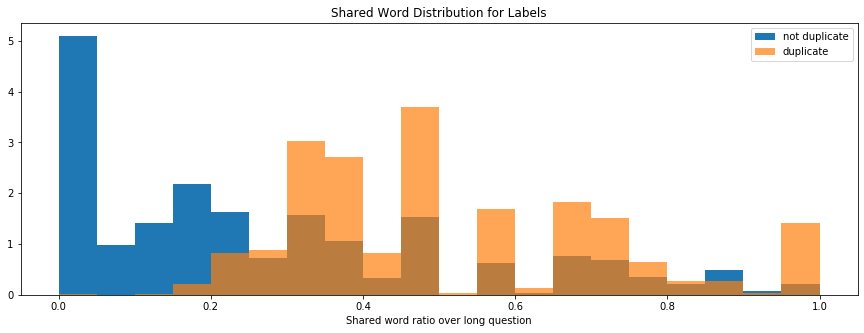

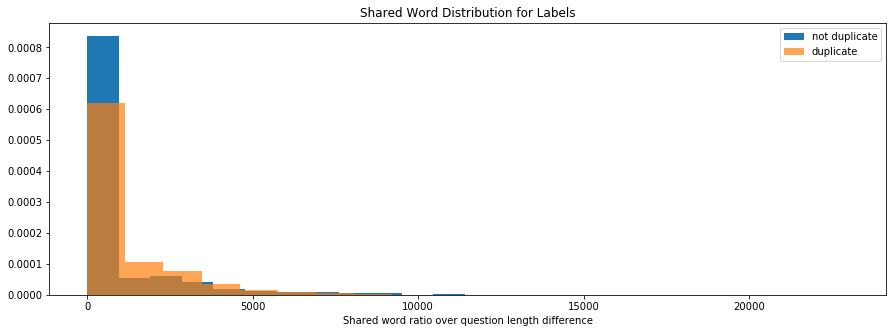

In [18]:
for feat, xlab in zip([match_word_rate, mwr_min, mwr_max, mwr_diff],
                      ['Shared word ratio', 'Shared word ratio over short question',
                       'Shared word ratio over long question','Shared word ratio over question length difference']):    
    plt.figure(figsize=(15,5))
    plt.hist(feat[train['is_duplicate'] == 0], bins=20, density=True, label='not duplicate')
    plt.hist(feat[train['is_duplicate'] == 1], bins=20, alpha=0.7, density=True, label='duplicate')
    plt.legend()
    plt.title('Shared Word Distribution for Labels')
    plt.xlabel(xlab)
    plt.show()

These features seem to be useful based on the histograms since we can see the differentiation between the duplicate and not duplicate questions as the shared word ratio related feature changes. Their predictive power for not duplicate questions seems to be superior over the duplicated ones 

**Feature 2 - TF-IDF**

Second feature we will generate is TF-IDF for shared words. TF-IDF will put more emphasis on uncommon words that are shared between questions so that we will offset the effect very common words and possibly get a better predictive power for duplicate questions.

In [19]:
def stop_remover(string):
    new_string = []
    for word in str(string).split():
        if word not in stops:
            new_string.append(word)
    return ' '.join(new_string)
train_qs_no_stops = train_qs.apply(stop_remover)

In [20]:
from collections import Counter

def get_weight(count, eps=10000, min_count=2):
    if count < min_count:
        return 0
    else:
        return 1 / (count + eps)

words = (" ".join(train_qs_no_stops)).lower().split()
counts = Counter(words)
weights = {word: get_weight(count) for word, count in counts.items()}

In [21]:
def tf_idf_weights(row):
    q1_words = {}
    q2_words = {}
    
    for word in str(row.question1).lower().split():
        if word not in stops:
            q1_words[word] = 1
    
    for word in str(row.question2).lower().split():
        if word not in stops:
            q2_words[word] = 1
    
    if len(q1_words) == 0 or len(q2_words) == 0:
        return 0
    
    shared_weights = [weights.get(w, 0) for w in q1_words.keys() if w in q2_words] + [weights.get(w, 0) for w in q2_words.keys() if w in q1_words]
    total_weights = [weights.get(w, 0) for w in q1_words.keys()] + [weights.get(w, 0) for w in q2_words.keys()]
    return np.sum(shared_weights) / np.sum(total_weights)



In [22]:
train_match_weights = train.apply(tf_idf_weights, axis=1, raw=True)

Text(0.5, 0, 'Shared word ratio')

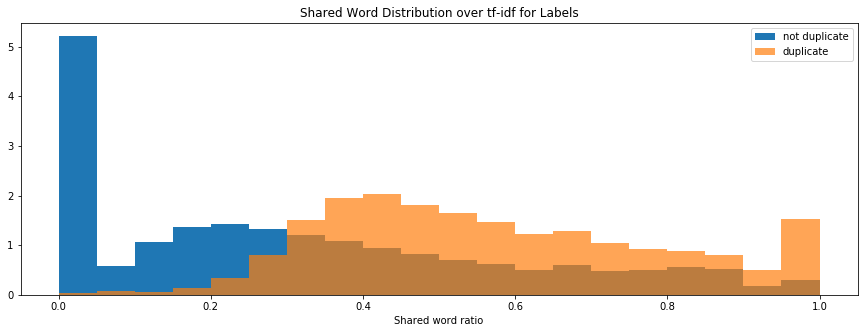

In [23]:
plt.figure(figsize=(15,5))
plt.hist(train_match_weights[train['is_duplicate'] == 0], bins=20, density=True, label='not duplicate')
plt.hist(train_match_weights[train['is_duplicate'] == 1], bins=20, alpha=0.7, density=True, label='duplicate')
plt.legend()
plt.title('Shared Word Distribution over tf-idf for Labels')
plt.xlabel('Shared word ratio')

It seems like tf-idf feature has slightly less predictive value on it's own compared to common word ratios. However, together they might be more powerful than each of them individually. 

**Feature 3 - Longest Common Substring Ratio**

We will use the ratio of longest common substring's length to the shorter question's length as a feature. We expect duplicated questions to have higher ratio.

In [24]:
from difflib import SequenceMatcher

In [25]:
def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    return x

In [26]:
def longestSubstring(str1,str2): 
  
     # initialize SequenceMatcher object with  
     # input string 
    seqMatch = SequenceMatcher(None,str1,str2) 
  
     # find match of longest sub-string 
     # output will be like Match(a=0, b=0, size=5) 
    match = seqMatch.find_longest_match(0, len(str1), 0, len(str2)) 
    lcs = str1[match.a: match.a + match.size]
    if len(lcs) == 0:
        return 0
    else:
        return len(lcs) / (min(len(str1), len(str2)) + 1)

In [27]:
def extract_lcs(df):
    df['question1'] = df['question1'].apply(preprocess)
    df['question2'] = df['question2'].apply(preprocess)
    
    df['lcs_ratio'] = df.apply(lambda x: longestSubstring(x['question1'], x['question2']), axis=1)
    return df['lcs_ratio']

In [28]:
lcs_ratio = extract_lcs(train)

Text(0.5, 0, 'Lcs Ratio')

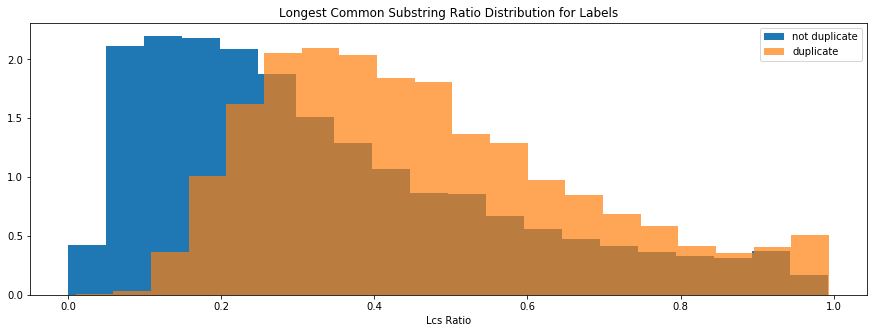

In [29]:
plt.figure(figsize=(15,5))
plt.hist(lcs_ratio[train['is_duplicate'] == 0], bins=20, density=True, label='not duplicate')
plt.hist(lcs_ratio[train['is_duplicate'] == 1], bins=20, alpha=0.7, density=True, label='duplicate')
plt.legend()
plt.title('Longest Common Substring Ratio Distribution for Labels')
plt.xlabel('Lcs Ratio')

**Feature 4 - Different Similarity Metrics**

For this feature we are going to be using fuzzywuzzy library that allows to use different metrics to measure similarity between two strings. We will be using 4 metrics which are Qratio, partial ratio, token sort ratio and token set ratio. Details about these metrics can be found on fuzzywuzzy documentation. Essentially we will be building four new features in this part.

In [30]:
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

In [31]:
def extract_fuzzy_fetures(df):
    df['Qratio'] = df.apply(lambda x: fuzz.QRatio(x['question1'], x['question2']), axis=1)
    df['partial_ratio'] = df.apply(lambda x: fuzz.partial_ratio(x['question1'], x['question2']), axis=1)
    df['token_set_ratio'] = df.apply(lambda x: fuzz.token_set_ratio(x['question1'], x['question2']), axis=1)
    df['token_sort_ratio'] = df.apply(lambda x: fuzz.token_sort_ratio(x['question1'], x['question2']), axis=1)
    return df

**Putting it altogether**

At this part, we will generate all the features we've come up so far for the train and test sets. Please note that for the first two features we tested their effectivenes without preprocessing however this time all the features will be generated after preprocessing steps. 

In [32]:
def extract_all_features(df):
    df['question1'] = df['question1'].apply(preprocess)
    df['question2'] = df['question2'].apply(preprocess)
    
    train_match_rates = df.apply(lambda x: matching_words_rate(x["question1"], x["question2"]), axis=1)
    df['match_word_rate'] = train_match_rates.apply(lambda x: x[0])
    df['mwr_min'] = train_match_rates.apply(lambda x: x[1])
    df['mwr_max'] = train_match_rates.apply(lambda x: x[2])
    df['mwr_diff'] = train_match_rates.apply(lambda x: x[3])
    df['tfidf_weights'] = df.apply(tf_idf_weights, axis=1, raw=True)
    df['lcs_ratio'] = df.apply(lambda x: longestSubstring(x['question1'], x['question2']), axis=1)
    df = extract_fuzzy_fetures(df)
    return df        

Lastly, we are going to generate some meta features based on frequency of each question in the dataset. These features were discovered and shared by Jared Turkewitz, who is a great contributer in the kaggle community and we'll just implement these features to get a small performance boost in our model.

In [33]:
def extract_meta_feats(train_orig, test_orig):
    df1 = train_orig[['question1']].copy()
    df2 = train_orig[['question2']].copy()
    df1_test = test_orig[['question1']].copy()
    df2_test = test_orig[['question2']].copy()

    df2.rename(columns = {'question2':'question1'},inplace=True)
    df2_test.rename(columns = {'question2':'question1'},inplace=True)

    train_questions = df1.append(df2)
    train_questions = train_questions.append(df1_test)
    train_questions = train_questions.append(df2_test)
    train_questions.drop_duplicates(subset = ['question1'],inplace=True)

    train_questions.reset_index(inplace=True,drop=True)
    questions_dict = pd.Series(train_questions.index.values,index=train_questions.question1.values).to_dict()
    train_cp = train_orig.copy()
    test_cp = test_orig.copy()
    train_cp.drop(['qid1','qid2'],axis=1,inplace=True)

    test_cp['is_duplicate'] = -1
    test_cp.rename(columns={'test_id':'id'},inplace=True)
    comb = pd.concat([train_cp,test_cp])

    comb['q1_hash'] = comb['question1'].map(questions_dict)
    comb['q2_hash'] = comb['question2'].map(questions_dict)

    q1_vc = comb.q1_hash.value_counts().to_dict()
    q2_vc = comb.q2_hash.value_counts().to_dict()

    def try_apply_dict(x,dict_to_apply):
        try:
            return dict_to_apply[x]
        except KeyError:
            return 0
    #map to frequency space
    comb['q1_freq'] = comb['q1_hash'].map(lambda x: try_apply_dict(x,q1_vc) + try_apply_dict(x,q2_vc))
    comb['q2_freq'] = comb['q2_hash'].map(lambda x: try_apply_dict(x,q1_vc) + try_apply_dict(x,q2_vc))

    train_comb = comb[comb['is_duplicate'] >= 0][['id', 'q1_hash','q2_hash','q1_freq','q2_freq']]
    test_comb = comb[comb['is_duplicate'] < 0][['id', 'q1_hash','q2_hash','q1_freq','q2_freq']]
    test_comb.rename(columns={'id': 'test_id'}, inplace=True)
    return train_comb, test_comb

In [45]:
train_processed = extract_all_features(train)

In [46]:
test_processed = extract_all_features(test)

In [47]:
train_metas, test_metas = extract_meta_feats(train, test)

In [49]:
train_metas.head()

,id,q1_hash,q2_hash,q1_freq,q2_freq
0,0,0,290230,1,2
1,1,1,16732,8,3
2,2,2,290231,2,1
3,3,3,290232,1,1
4,4,4,290233,3,1


In [50]:
train_processed = train_processed.merge(train_metas, how='left', on='id')

In [53]:
test_processed = test_processed.merge(test_metas, how='left', on='test_id')

In [54]:
train_processed.head()

,id,qid1,qid2,question1,question2,is_duplicate,lcs_ratio,match_word_rate,mwr_min,mwr_max,mwr_diff,tfidf_weights,Qratio,partial_ratio,token_set_ratio,token_sort_ratio,q1_hash,q2_hash,q1_freq,q2_freq
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,0.965517,0.727273,0.799840,0.666556,3.996004,0.772164,93,98,100,93,0,290230,1,2
1,1,3,4,what is the story of kohinoor (koh-i-noor) dia...,what would happen if the indian government sto...,0,0.576923,0.307692,0.499875,0.222198,0.399920,0.361758,66,75,86,63,1,16732,8,3
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,0.166667,0.363636,0.399920,0.333278,1.998002,0.355191,54,53,66,66,2,290231,2,1
3,3,7,8,why am i mentally very lonely? how can i solve...,find the remainder when [math]23^{24}[/math] i...,0,0.039216,0.000000,0.000000,0.000000,0.000000,0.000000,35,36,36,36,3,290232,1,1
4,4,9,10,"which one dissolve in water quikly sugar, salt...",which fish would survive in salt water?,0,0.150000,0.000000,0.000000,0.000000,0.000000,0.000000,46,54,67,47,4,290233,3,1


#### Preparing the data to feed into the machine learning model

In [55]:
#Based on previous submission scores, it's been concluded that test set has %16.5 duplicate questions, in order to
#match that ratio in our train set, we will oversample not duplicate questions with the following code
temp_x = train_processed.copy()
pos_boostrap_sample = temp_x[temp_x["is_duplicate"] == 0].sample(n = 500000, replace = True)
temp_x = pd.concat((pos_boostrap_sample, temp_x))

In [56]:
X_train = temp_x[['match_word_rate', 'mwr_min', 'mwr_max', 'mwr_diff', 'tfidf_weights', 'lcs_ratio', 'Qratio', 
                  'partial_ratio', 'token_set_ratio', 'token_sort_ratio', 'q1_freq', 'q2_freq', 'q1_hash', 'q2_hash']]
Y_train = temp_x['is_duplicate']
X_test = test_processed[['match_word_rate', 'mwr_min', 'mwr_max', 'mwr_diff', 'tfidf_weights', 'lcs_ratio', 'Qratio', 
                  'partial_ratio', 'token_set_ratio', 'token_sort_ratio', 'q1_freq', 'q2_freq', 'q1_hash', 'q2_hash']]

### Model Implementation Using Gradient Boosting Trees(Machine) 

We will build a model using one of the very well known gradient boosting machine frameworks, XGBoost, using the features we generated. Gradient Boosting Machine models gained a lot of popularity in the recent years and we see them producing very decent results in online machine learning competitions.
First we split our data as train and validation to test random search findings after the cross validation:

In [57]:
from sklearn.model_selection import train_test_split
train_x, val_x, train_y, val_y = train_test_split(X_train, Y_train, test_size=0.2, random_state=21)

In [58]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

We'll use random search method for hyperparameter tuning. Scikit-learn library has a very handy feature called RandomizedSearchCV which allows us to choose near optimal parameters via random grid search from given parameters.

In [60]:
%%time

# Model tuning with 5-fold cross-validation
params_xgb = {'n_estimators' : [500],
              'gamma':[0, 1, 5], 
              'learning_rate' : np.linspace(.01, 0.1, 10, endpoint=True),
              'colsample_bytree':[0.8, 0.9, 1],
              'max_depth' : np.linspace(2, 8, 7, endpoint=True, dtype=int),
              'reg_lambda':[0.2, 0.3, 0.4]
                 }
cv_xgb = RandomizedSearchCV(xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', random_state=42), 
                                              param_distributions=params_xgb, cv=5, n_jobs=-1)
# X_train contains all the features 
cv_xgb.fit(X_train, Y_train)

CPU times: user 16min 41s, sys: 2.96 s, total: 16min 44s
Wall time: 2h 26min 25s


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1,
                                           eval_metric='logloss', gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           rand...
                   iid='warn', n_iter=10, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.8, 0.9, 1],
                                        'gamma': [0

In [61]:
cv_xgb.best_params_ #Show best parameters

{'reg_lambda': 0.4,
 'n_estimators': 500,
 'max_depth': 7,
 'learning_rate': 0.09000000000000001,
 'gamma': 0,
 'colsample_bytree': 0.8}

In [62]:
eval_metric = ['logloss']
eval_set = [(train_x, train_y), (val_x, val_y)]
clf_xgb_model = xgb.XGBClassifier(random_state=42,
                                  objective='binary:logistic',
                                  n_estimators= 2000, #we set this number high since we have early stop mechanism
                                  gamma=cv_xgb.best_params_['gamma'],
                                  learning_rate=cv_xgb.best_params_['learning_rate'],
                                  reg_lambda=cv_xgb.best_params_['reg_lambda'],
                                  max_depth= cv_xgb.best_params_['max_depth'],
                                  colsample_bytree=cv_xgb.best_params_['colsample_bytree'],
                                  n_jobs=-1)
clf_xgb_model.fit(X_train, Y_train, eval_metric=eval_metric, eval_set=eval_set, verbose=10)

[0]	validation_0-logloss:0.634331	validation_1-logloss:0.636122
[10]	validation_0-logloss:0.370656	validation_1-logloss:0.370182
[20]	validation_0-logloss:0.289222	validation_1-logloss:0.288936
[30]	validation_0-logloss:0.259205	validation_1-logloss:0.25908
[40]	validation_0-logloss:0.247183	validation_1-logloss:0.246318
[50]	validation_0-logloss:0.240376	validation_1-logloss:0.240247
[60]	validation_0-logloss:0.237123	validation_1-logloss:0.23723
[70]	validation_0-logloss:0.235061	validation_1-logloss:0.234932
[80]	validation_0-logloss:0.233549	validation_1-logloss:0.233293
[90]	validation_0-logloss:0.231758	validation_1-logloss:0.23142
[100]	validation_0-logloss:0.230219	validation_1-logloss:0.229858
[110]	validation_0-logloss:0.228665	validation_1-logloss:0.228274
[120]	validation_0-logloss:0.227005	validation_1-logloss:0.226682
[130]	validation_0-logloss:0.226187	validation_1-logloss:0.22588
[140]	validation_0-logloss:0.225237	validation_1-logloss:0.224899
[150]	validation_0-loglos

[1250]	validation_0-logloss:0.182251	validation_1-logloss:0.182344
[1260]	validation_0-logloss:0.181896	validation_1-logloss:0.181996
[1270]	validation_0-logloss:0.181689	validation_1-logloss:0.181794
[1280]	validation_0-logloss:0.181295	validation_1-logloss:0.181417
[1290]	validation_0-logloss:0.180991	validation_1-logloss:0.181097
[1300]	validation_0-logloss:0.180853	validation_1-logloss:0.180951
[1310]	validation_0-logloss:0.180501	validation_1-logloss:0.180575
[1320]	validation_0-logloss:0.180307	validation_1-logloss:0.180387
[1330]	validation_0-logloss:0.180037	validation_1-logloss:0.180129
[1340]	validation_0-logloss:0.179954	validation_1-logloss:0.180046
[1350]	validation_0-logloss:0.179588	validation_1-logloss:0.179662
[1360]	validation_0-logloss:0.179438	validation_1-logloss:0.179512
[1370]	validation_0-logloss:0.179087	validation_1-logloss:0.179189
[1380]	validation_0-logloss:0.178837	validation_1-logloss:0.178938
[1390]	validation_0-logloss:0.178714	validation_1-logloss:0.17

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0,
              learning_rate=0.09000000000000001, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=None, n_estimators=2000, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=0.4, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

Please note that our train and validation loss are very close to each other which usually means model is not overfitting.

**Kaggle Submission**

Note: This part is preparation for the kaggle submission and if you are not interested in the kaggle competition you can skip to the Conclusion part

In [63]:
preds = clf_xgb_model.predict_proba(X_test)
preds = np.array([x[1] for x in preds])
sub = pd.DataFrame()
sub['test_id'] = test['test_id']
sub['is_duplicate'] = preds
sub.to_csv('finaltuned_xgb.csv', index=False)

### Conclusion

In this project, we achieved decent results with very little effort in feature engineering and model building. We put the most emphasis on the data exploration part. Our validation logarithmic loss is around 0.16 which is very impressive for a relatively light-weight model. 

Results can be improved through more extensive feature generation that includes more in depth data pre and post processing,using algorithms such as word2vec or doc2vec and getting embeddings, and using more advanced models such as RNN with LSTM. 

However this project proves that with a careful data exploration, we can generate quick and efficient models that achieve pretty good results.

Understanding the data that we are dealing with is far more important than the tools we use. 